In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE=224
BATCH_SIZE=32
CHANNELS=3
EPOCHS=100

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory("skin_train",
                                                    shuffle=True,
                                                   image_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                   batch_size=BATCH_SIZE)

Found 2864 files belonging to 8 classes.


In [4]:
class_names =dataset.class_names
class_names

['Acne and Rosacea Photos',
 'Actinic Keratosis  Carcinoma and Malignant Lesions',
 'Bullous Disease Photos',
 'Cellulitis Impetigo and Bacterial Infections',
 'Hair Loss Photos Alopecia and other Hair Diseases',
 'Nail Fungus and other Nail Disease',
 'Poison Ivy Photos and other Contact Dermatitis',
 'Vasculitis Photos']

In [5]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(image_batch.numpy())

(32, 224, 224, 3)
[[[[ 25.438932    21.625477    46.74649   ]
   [ 24.689331    19.844784    52.1246    ]
   [ 31.157522    27.771044    55.552452  ]
   ...
   [  2.1087718    2.1087718    4.108772  ]
   [ 47.19338     45.19338     48.19338   ]
   [  2.5126164    1.0084109    3.5126164 ]]

  [[ 30.989712    28.989712    50.435425  ]
   [  9.082342     7.495529    33.693947  ]
   [ 20.176668    18.362335    41.553024  ]
   ...
   [  0.8196948    0.8196948    2.8196948 ]
   [  9.708788     9.708788    11.708788  ]
   [  1.8184336    1.8184336    3.8184338 ]]

  [[  6.9319963    6.4028196   25.303726  ]
   [  1.4804678    0.5982938   22.921555  ]
   [ 17.89469     15.8946905   38.058434  ]
   ...
   [  0.7647418    1.6828792    3.6828792 ]
   [  7.230302     7.230302     9.230302  ]
   [  2.7801616    2.7801616    4.7801614 ]]

  ...

  [[  1.7181079    0.31493053   9.718107  ]
   [  3.2374697    1.4138309   11.8847475 ]
   [  2.1049328    1.0104537    9.010453  ]
   ...
   [  0.9451301  

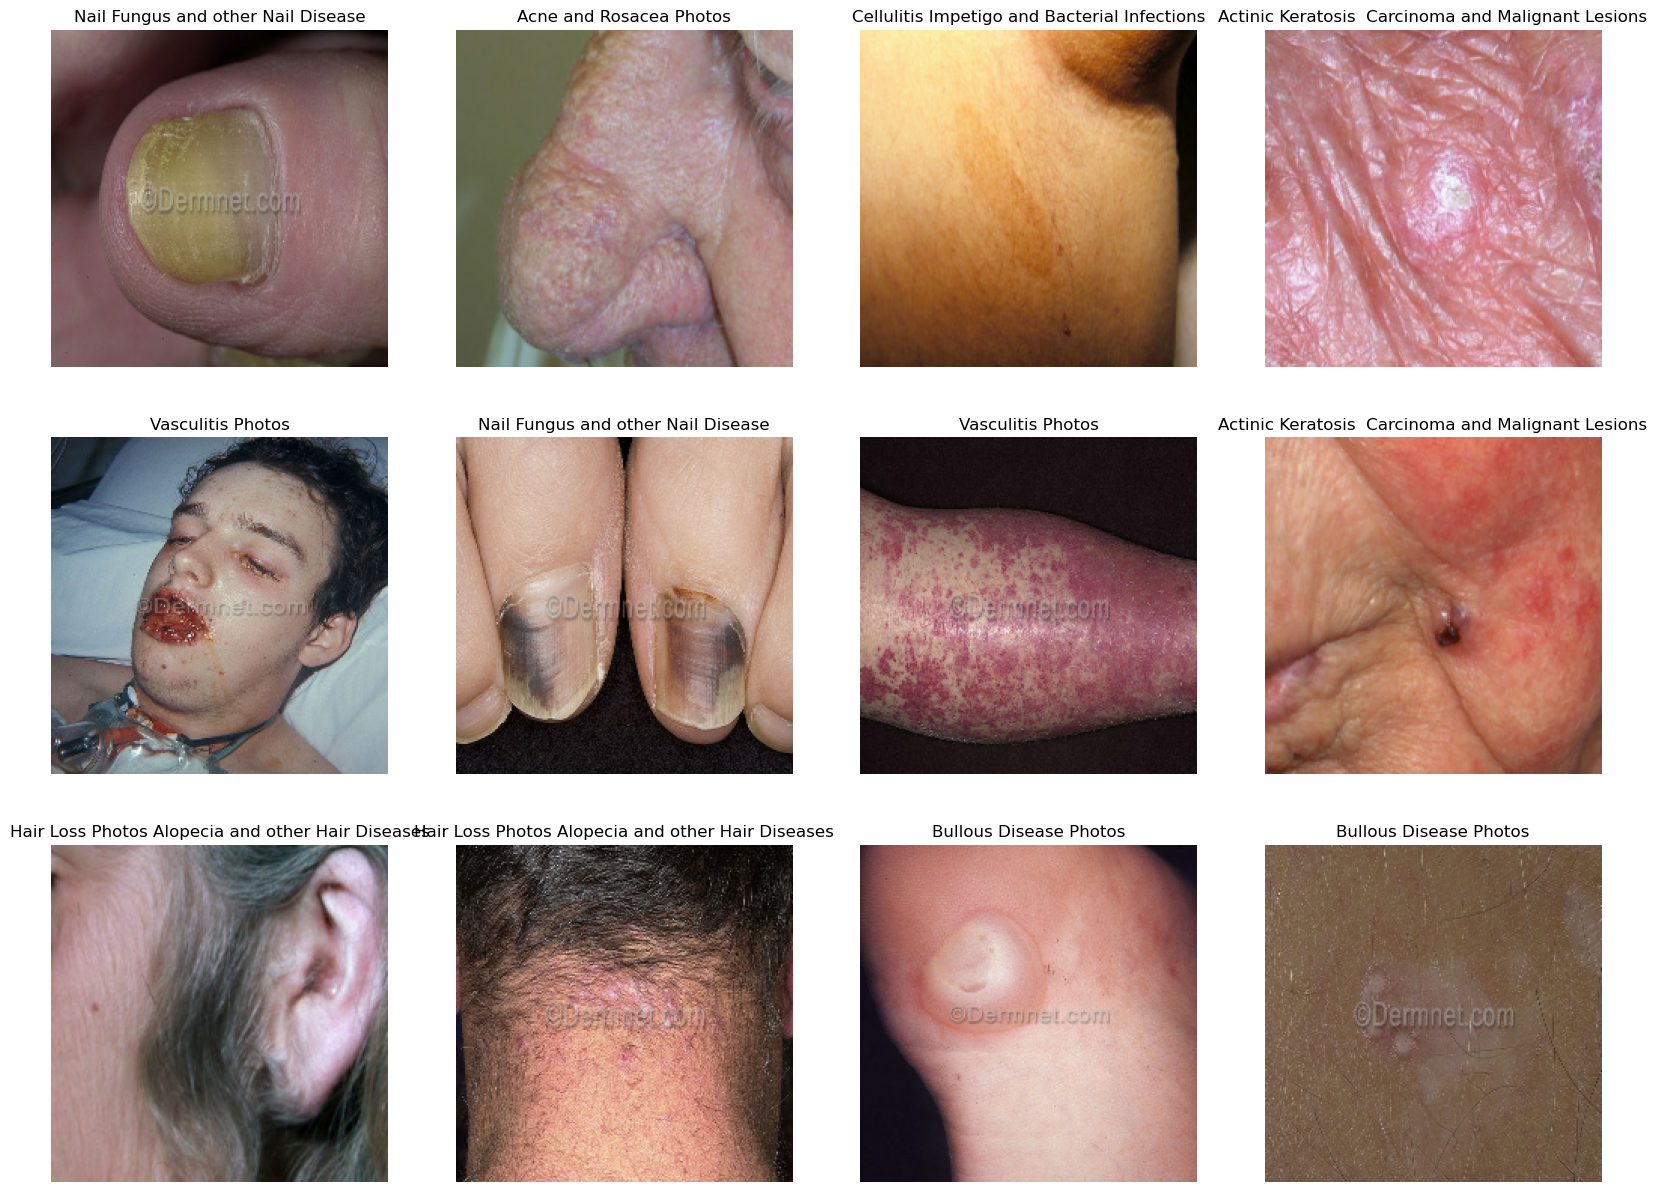

In [6]:
plt.figure(figsize=(20,15))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    

In [7]:
len(dataset)

90

In [8]:
# 80% ==>training
# 20% ==>10% validation,10% test

In [9]:
def get_dataset_partition_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert(train_split+test_split+val_split) ==1
    ds_size =len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size =int(train_split*ds_size)
    val_size =int(val_split*ds_size)
    train_ds =ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds
    


In [10]:
train_ds,val_ds,test_ds=get_dataset_partition_tf(dataset)

In [11]:
len(train_ds)

72

In [12]:
len(val_ds)

9

In [13]:
len(test_ds)


9

In [14]:
train_ds =train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds =val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds =test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy()/255)

[[[0.6084559  0.42291668 0.39215687]
  [0.60808825 0.41409314 0.38664216]
  [0.62536764 0.42009804 0.3957108 ]
  ...
  [0.70367646 0.4762255  0.42745098]
  [0.70980394 0.48443627 0.4357843 ]
  [0.6932598  0.48296568 0.4497549 ]]

 [[0.6117204  0.4371838  0.40255493]
  [0.6099019  0.42183122 0.39232484]
  [0.6231913  0.42783612 0.4004262 ]
  ...
  [0.6688551  0.4560339  0.41922924]
  [0.68525964 0.47355458 0.4437642 ]
  [0.69737065 0.4960237  0.4776846 ]]

 [[0.6356076  0.46625254 0.43097207]
  [0.62298614 0.44470087 0.4149269 ]
  [0.6363412  0.4457934  0.4251718 ]
  ...
  [0.6853959  0.48763022 0.4761489 ]
  [0.703857   0.51917565 0.51492196]
  [0.7159976  0.52867043 0.5282656 ]]

 ...

 [[0.8130583  0.62233466 0.70340234]
  [0.8468187  0.666012   0.7438364 ]
  [0.8032181  0.6323392  0.7070753 ]
  ...
  [0.8459337  0.7062596  0.7552583 ]
  [0.88672215 0.7488257  0.8038617 ]
  [0.8554914  0.6975548  0.7527056 ]]

 [[0.8745847  0.6929752  0.744447  ]
  [0.8410943  0.65281314 0.7038533 ]


In [16]:
resize_and_rescale =tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [17]:
data_augmentation =tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [18]:
input_shape =(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=8
model=models.Sequential([resize_and_rescale,
                  data_augmentation,
                  layers.Conv2D(16,kernel_size=(3,3),activation='relu',input_shape=input_shape),
                  layers.MaxPooling2D((2,2)),
                  #layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
                  #layers.MaxPooling2D((2,2)),
                  #layers.Conv2D(128,kernel_size=(3,3),activation='relu'),
                  #layers.MaxPooling2D((2,2)),
                  layers.Conv2D(32,(3,3),activation='relu'),
                  layers.MaxPooling2D((2,2)),
                  layers.Conv2D(64,(3,3),activation='relu'),
                  layers.MaxPooling2D((2,2)),
                         
                  layers.Conv2D(128,(3,3),activation='relu'),
                  layers.MaxPooling2D((2,2)),
                         
                  layers.Flatten(),
                  layers.Dense(512,activation='relu'),
                  layers.Dense(n_classes,activation='softmax'),
])
model.build(input_shape=input_shape)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 222, 222, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (32, 111, 111, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 109, 109, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 54, 54, 32)          0         
 g2D)                                                 

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
history= model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/100
72/72 [==============================] - 42s 544ms/step - loss: 1.9892 - accuracy: 0.2057 - val_loss: 1.8338 - val_accuracy: 0.2847
Epoch 2/100
72/72 [==============================] - 41s 574ms/step - loss: 1.8514 - accuracy: 0.2734 - val_loss: 1.7756 - val_accuracy: 0.3403
Epoch 3/100
72/72 [==============================] - 42s 583ms/step - loss: 1.7717 - accuracy: 0.3299 - val_loss: 1.6925 - val_accuracy: 0.3611
Epoch 4/100
72/72 [==============================] - 43s 592ms/step - loss: 1.7344 - accuracy: 0.3355 - val_loss: 1.7301 - val_accuracy: 0.3681
Epoch 5/100
72/72 [==============================] - 43s 598ms/step - loss: 1.7025 - accuracy: 0.3576 - val_loss: 1.7767 - val_accuracy: 0.3438
Epoch 6/100
72/72 [==============================] - 43s 592ms/step - loss: 1.6579 - accuracy: 0.3780 - val_loss: 1.6317 - val_accuracy: 0.4097
Epoch 7/100
72/72 [==============================] - 43s 604ms/step - loss: 1.5920 - accuracy: 0.3997 - val_loss: 1.6621 - val_accuracy:

72/72 [==============================] - 47s 647ms/step - loss: 0.4279 - accuracy: 0.8520 - val_loss: 0.9012 - val_accuracy: 0.7431
Epoch 58/100
72/72 [==============================] - 46s 644ms/step - loss: 0.3843 - accuracy: 0.8720 - val_loss: 0.8757 - val_accuracy: 0.8056
Epoch 59/100
72/72 [==============================] - 47s 654ms/step - loss: 0.3720 - accuracy: 0.8811 - val_loss: 0.8504 - val_accuracy: 0.7951
Epoch 60/100
72/72 [==============================] - 46s 645ms/step - loss: 0.4171 - accuracy: 0.8542 - val_loss: 1.0134 - val_accuracy: 0.7639
Epoch 61/100
72/72 [==============================] - 48s 664ms/step - loss: 0.3828 - accuracy: 0.8694 - val_loss: 0.8881 - val_accuracy: 0.7917
Epoch 62/100
72/72 [==============================] - 47s 647ms/step - loss: 0.3914 - accuracy: 0.8620 - val_loss: 0.8892 - val_accuracy: 0.7812
Epoch 63/100
72/72 [==============================] - 46s 643ms/step - loss: 0.3876 - accuracy: 0.8607 - val_loss: 0.6846 - val_accuracy: 0.819

In [22]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 6s 232ms/step - loss: 0.9543 - accuracy: 0.8264


In [23]:
history.history['accuracy']

[0.2057291716337204,
 0.2734375,
 0.3298611044883728,
 0.3355034589767456,
 0.3576388955116272,
 0.3780381977558136,
 0.3997395932674408,
 0.4040798544883728,
 0.4288194477558136,
 0.4461805522441864,
 0.4691840410232544,
 0.4670138955116272,
 0.4657118022441864,
 0.4930555522441864,
 0.4982638955116272,
 0.5151909589767456,
 0.5104166865348816,
 0.5212673544883728,
 0.5381944179534912,
 0.5551215410232544,
 0.5681423544883728,
 0.57421875,
 0.5811631679534912,
 0.6089409589767456,
 0.6015625,
 0.6167534589767456,
 0.5998263955116272,
 0.6423611044883728,
 0.6397569179534912,
 0.6471354365348816,
 0.6740451455116272,
 0.6575520634651184,
 0.6796875,
 0.69140625,
 0.7074652910232544,
 0.7213541865348816,
 0.7296006679534912,
 0.7274305820465088,
 0.7521701455116272,
 0.75390625,
 0.7625868320465088,
 0.7621527910232544,
 0.7808159589767456,
 0.78125,
 0.7847222089767456,
 0.7738715410232544,
 0.8038194179534912,
 0.8003472089767456,
 0.8190104365348816,
 0.80859375,
 0.8250868320465088,

In [24]:
acc=history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss = history.history['val_loss']

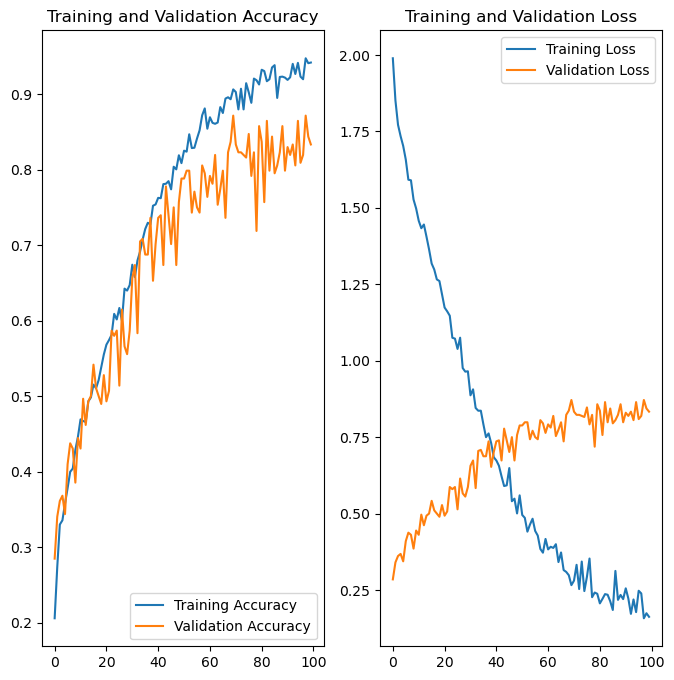

In [25]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_acc,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Hair Loss Photos Alopecia and other Hair Diseases
1/1 [==============================] - 0s 180ms/step
predicted label: Hair Loss Photos Alopecia and other Hair Diseases


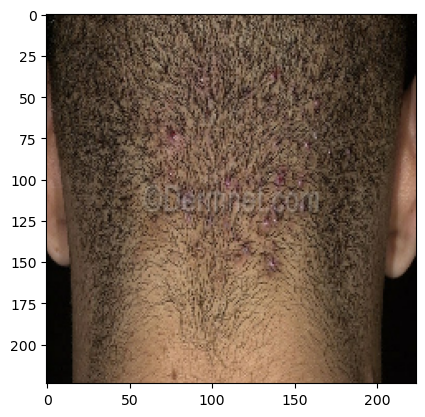

In [31]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    

In [27]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 57ms/step


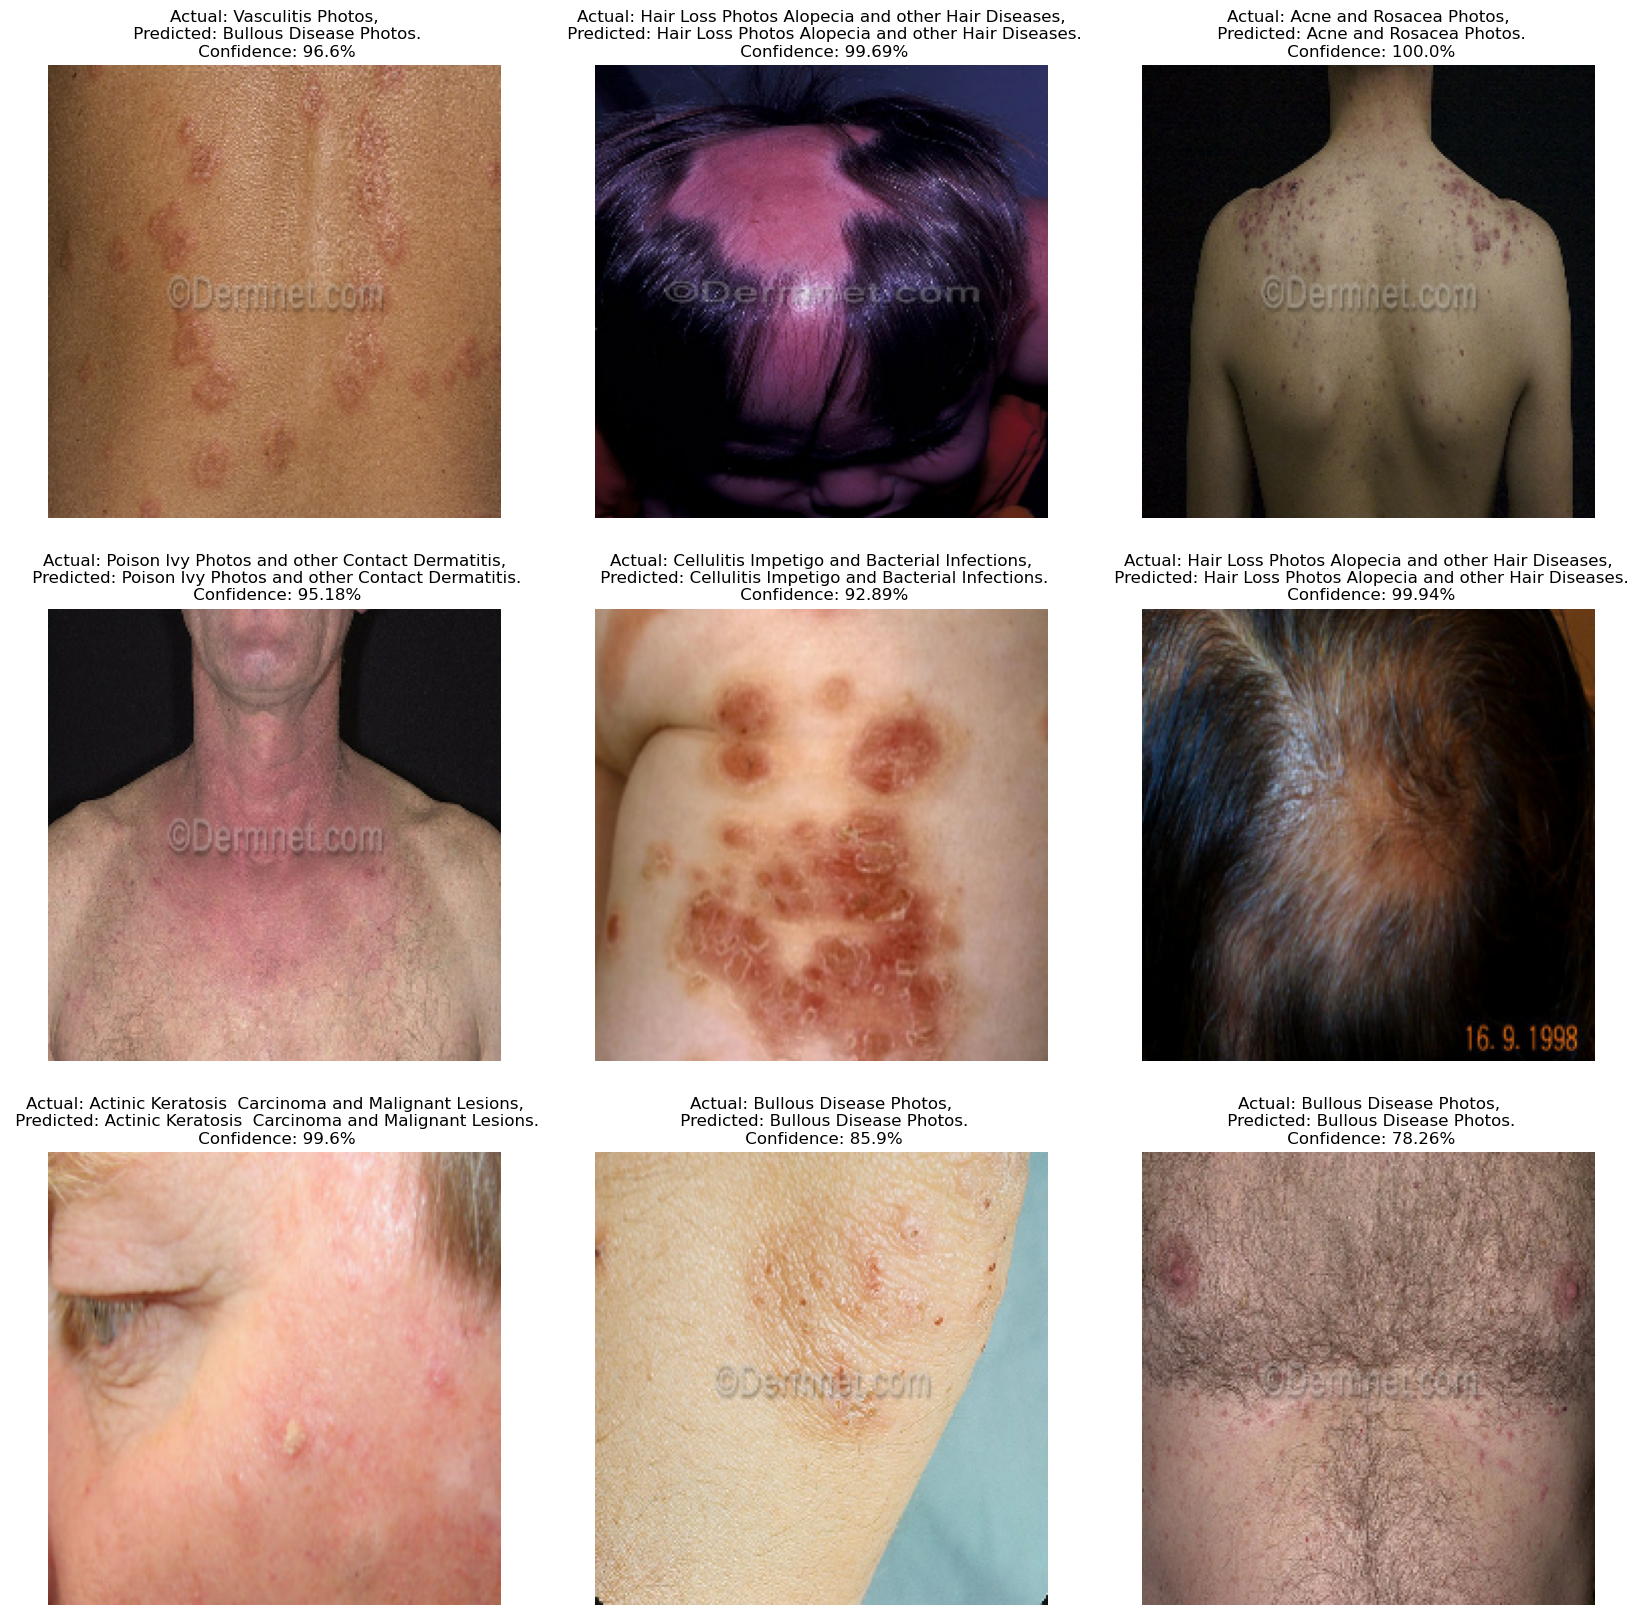

In [28]:
plt.figure(figsize=(20, 20))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [32]:
model.save("New2.keras")

In [30]:
import tkinter as tk
from tkinter import filedialog
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from PIL import Image, ImageTk  # To display the image in Tkinter

# Your code for loading the model, class_names, and test_ds

# Function to perform image classification and update labels
def classify_image():
    file_path = filedialog.askopenfilename()
    
    if not file_path:
        return
    
    img = Image.open(file_path)
    img = img.resize((img_width, img_height))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    batch_prediction = model.predict(img)
    predicted_label = class_names[np.argmax(batch_prediction[0])]

    actual_label.config(text="Actual Label: -")
    predicted_label_text.set(f"Predicted Label: {predicted_label}")

    # Display the selected image in the GUI
    img_tk = ImageTk.PhotoImage(Image.open(file_path).resize((200, 200)))
    image_label.config(image=img_tk)
    image_label.image = img_tk

# Create the main window
window = tk.Tk()
window.title("Image Classification Prediction")

# Define image dimensions
img_width, img_height = 224, 224

# Create a button to classify the image
classify_button = tk.Button(window, text="Classify Image", command=classify_image)
classify_button.pack()

# Labels to display actual and predicted labels
actual_label = tk.Label(window, text="Actual Label: -")
actual_label.pack()
predicted_label_text = tk.StringVar()
predicted_label = tk.Label(window, textvariable=predicted_label_text)
predicted_label.pack()

# Create a label to display the selected image
image_label = tk.Label(window)
image_label.pack()

# Start the Tkinter main loop
window.mainloop()


1/1 [==============================] - 0s 31ms/step
